# State Farm 

## Prepare 

In [1]:
#  built-in module
%matplotlib inline
%load_ext autoreload
%autoreload 2
from __future__ import division
import sys
import csv
import os
import random
from os.path import join as pjoin
from glob import glob
sys.path.append('..')

In [2]:
#  third party module, and utils
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from keras import optimizers, initializers, losses, callbacks, regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Flatten, InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D

from utils.commands import unzip, mkdir, call, count_file, KaggleCLI, execute_in, unzip_all
from utils.plot import plot_images, plot_confusion_matrix
from utils.training import fit_generator, wrap_data_gen

/home/ansible/WorkSpace/miniconda2/envs/kaggle/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# global variable
cli = KaggleCLI('state-farm-distracted-driver-detection')

data_path = pjoin(os.getcwd(), 'data')
model_path = pjoin(os.getcwd(), 'models')
sample_path = pjoin(data_path, 'sample')
train_name = 'train'
valid_name = 'valid'
test_name = 'ttest'
mkdir(model_path)

## Examine Data

### Loading data, settle data

In [5]:
# download and unzip data
cli.download_data()
for zfile in os.listdir(data_path):
    if zfile.endswith('.zip'):
        unzip(pjoin(data_path, zfile), data_path)

In [12]:
def settle_data(test_size=0.1, valid_size=0.2):
    train_path = pjoin(data_path, train_name)
    valid_path = pjoin(data_path, valid_name)
    test_path = pjoin(data_path, test_name)
    
    categories = [name for name in os.listdir(train_path) if os.path.isdir(pjoin(train_path, name))]
    
    for ctg in categories:
        all_data = os.listdir(pjoin(train_path, ctg))
        train, valid_test = train_test_split(all_data, test_size=test_size+valid_size)
        valid, test = train_test_split(valid_test, test_size=test_size/(test_size+valid_size))
        
        test_ctg_path = pjoin(test_path, ctg)
        valid_ctg_path = pjoin(valid_path, ctg)
        train_ctg_path = pjoin(train_path, ctg)
        mkdir(test_ctg_path)
        mkdir(valid_ctg_path)
#         print 'mv -t {} {}'.format(test_ctg_path, " ".join([pjoin(train_ctg_path, name) for name in test]))
#         print 'mv -t {} {}'.format(valid_ctg_path, " ".join([pjoin(train_ctg_path, name) for name in valid]))
        call('mv -t {} {}'.format(test_ctg_path, " ".join([pjoin(train_ctg_path, name) for name in test])))
        call('mv -t {} {}'.format(valid_ctg_path, " ".join([pjoin(train_ctg_path, name) for name in valid])))
        
settle_data()

In [24]:
def settle_sample_data(sample_size=0.1):
    for dn in [train_name, test_name, valid_name]:
        dp = pjoin(data_path, dn)
        categories = [name for name in os.listdir(dp) if os.path.isdir(pjoin(dp, name))]
        for ctg in categories:
            ctg_path = pjoin(dp, ctg)
            sample_ctg_path = pjoin(sample_path, dn, ctg)
            mkdir(sample_ctg_path)
            _, sample = train_test_split(os.listdir(ctg_path), test_size=sample_size)
#             print 'cp -t {} {}'.format(sample_ctg_path, " ".join([pjoin(ctg_path, name) for name in sample]))
            call('cp -t {} {}'.format(sample_ctg_path, " ".join([pjoin(ctg_path, name) for name in sample])))

settle_sample_data()

### Check how it looks 

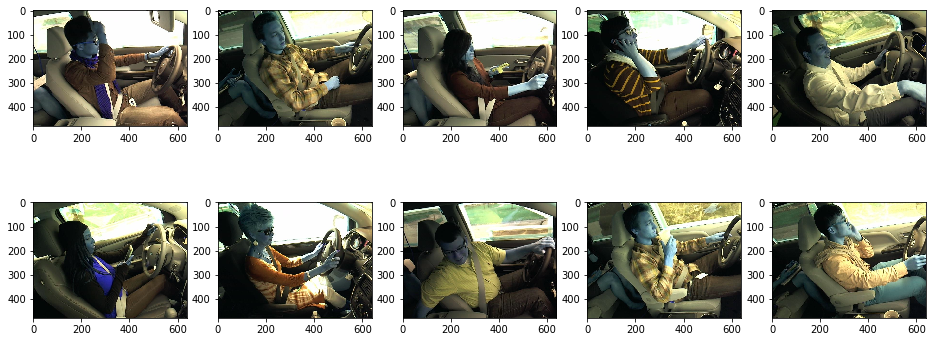

In [18]:
import random
sample_train_path = pjoin(data_path, train_name)
example_images = []

for ctg in os.listdir(sample_train_path):
    ctg_path = pjoin(sample_train_path, ctg)
    image_path = pjoin(ctg_path, random.choice(os.listdir(ctg_path)))
    image = cv2.imread(image_path)
    example_images.append(image)

plot_images(example_images, columns=5)

## Try different models

### Data flow

In [13]:
work_path = data_path
train_gen = ImageDataGenerator(    
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
)
train_flow = wrap_data_gen(pjoin(work_path, train_name), gen=train_gen).flow_from_directory(shuffle=True)
test_flow = wrap_data_gen(pjoin(work_path, test_name)).flow_from_directory()
valid_flow = wrap_data_gen(pjoin(work_path, valid_name)).flow_from_directory()


Found 15692 images belonging to 10 classes.
Found 2247 images belonging to 10 classes.
Found 4485 images belonging to 10 classes.


### Basic FC models

simple fc models are translation variance, so don't try data augmentation

In [48]:
lr_decay = callbacks.ReduceLROnPlateau(factor=0.2, patience=2, verbose=1, epsilon=0.001,)

In [49]:
def build_fc_model():
    # built model
    inputs = Input(shape=train_flow.image_shape)
    x = Flatten()(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(600, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    # a layer instance is callable on a tensor, and returns a tensor
    predictions = Dense(train_flow.num_classes, activation='softmax')(x)

    # This creates a model that includes
    # the Input layer and three Dense layers
    return Model(inputs=inputs, outputs=predictions)

fc_model = build_fc_model()

Epoch 1/3
49/49 [==============================] - 25s 509ms/step - loss: 1.7254 - acc: 0.4970 - val_loss: 0.4648 - val_acc: 0.8527


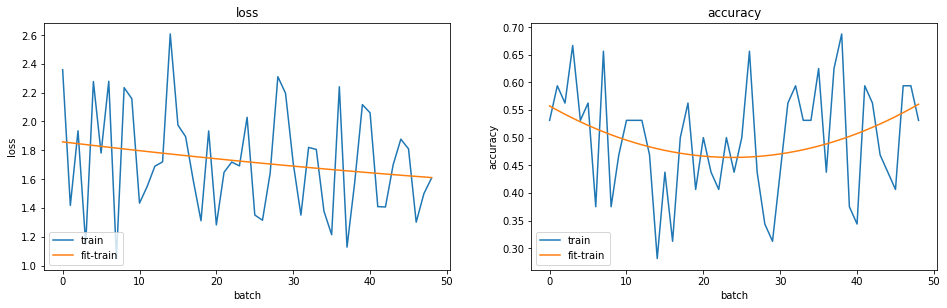

Epoch 2/3
49/49 [==============================] - 26s 525ms/step - loss: 1.4808 - acc: 0.5187 - val_loss: 0.4308 - val_acc: 0.8456


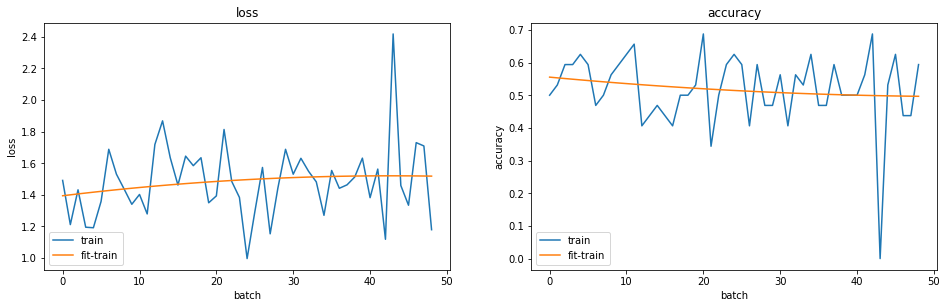

Epoch 3/3
49/49 [==============================] - 25s 511ms/step - loss: 1.3915 - acc: 0.5261 - val_loss: 0.3981 - val_acc: 0.8741


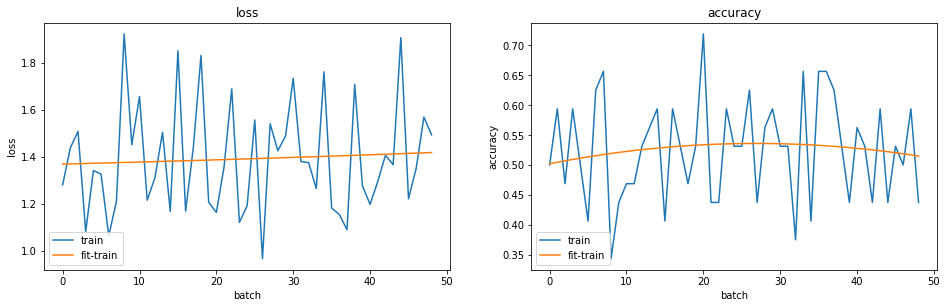

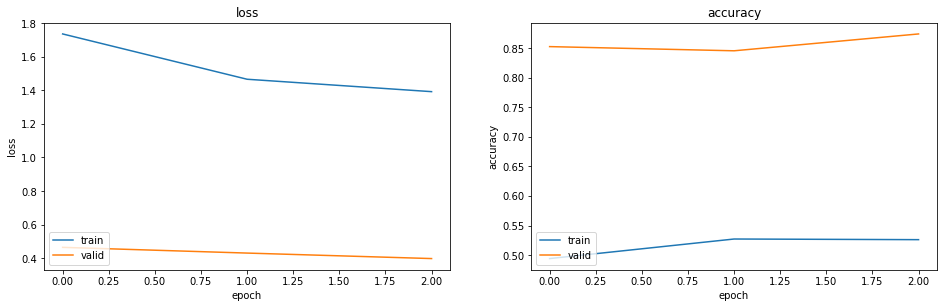

In [53]:
fc_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
fit_generator(fc_model, train_flow, valid_flow, epochs=3, 
              callbacks=[lr_decay]
             )

In [51]:
fc_model.evaluate_generator(test_flow)

[0.2069575000086646, 0.9437229437229437]

Here, I tested two fc model on sample data: 
    - linear model, 25 epochs, valid_loss 10.686
    - one hidden layer, 10 epoch, valid_loss 0.14, test_loss 0.169, 0.187 real_test_loss

### Conv models 

In [5]:
lr_decay = callbacks.ReduceLROnPlateau(factor=0.2, patience=2, verbose=1, epsilon=0.001,)

In [8]:
def build_conv_model():
    # built model
    inputs = Input(shape=train_flow.image_shape)
    x = BatchNormalization()(inputs)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    # a layer instance is callable on a tensor, and returns a tensor
    predictions = Dense(train_flow.num_classes, activation='softmax')(x)

    # This creates a model that includes
    # the Input layer and three Dense layers
    return Model(inputs=inputs, outputs=predictions)

conv_model = build_conv_model()

Epoch 1/12
49/49 [==============================] - 26s 538ms/step - loss: 2.2821 - acc: 0.3152 - val_loss: 3.8493 - val_acc: 0.3348


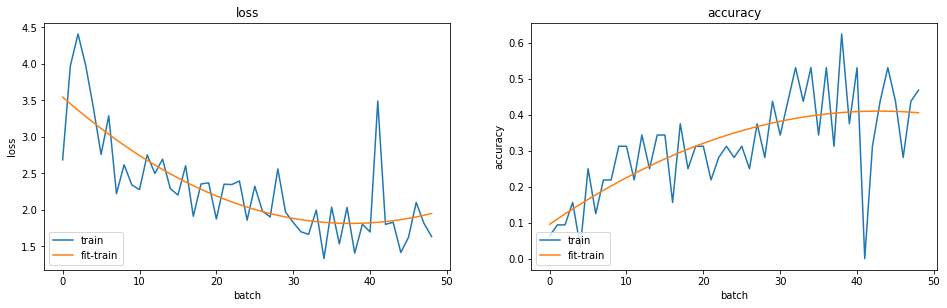

Epoch 2/12
49/49 [==============================] - 26s 531ms/step - loss: 1.1397 - acc: 0.6156 - val_loss: 1.2842 - val_acc: 0.6057


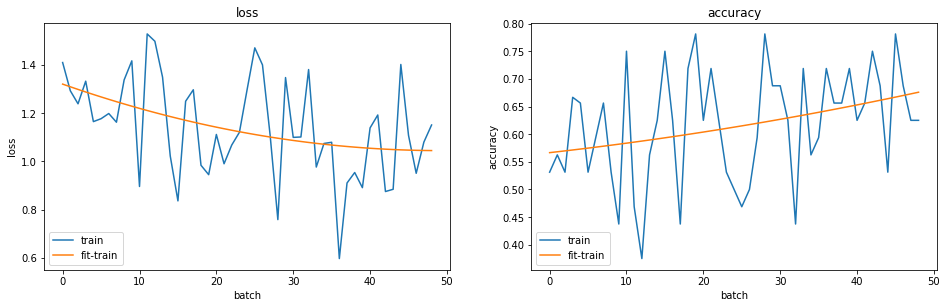

Epoch 3/12
49/49 [==============================] - 26s 525ms/step - loss: 0.7676 - acc: 0.7463 - val_loss: 0.6453 - val_acc: 0.7743


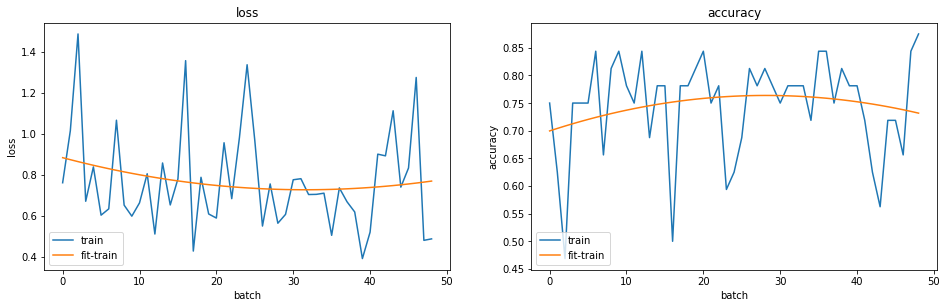

Epoch 4/12
49/49 [==============================] - 26s 528ms/step - loss: 0.5918 - acc: 0.8078 - val_loss: 1.2586 - val_acc: 0.6033


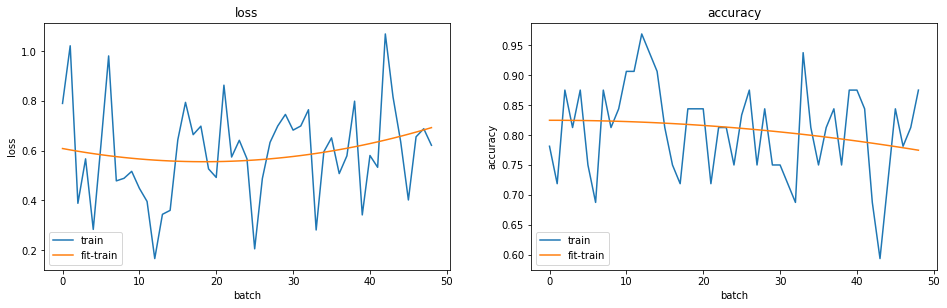

Epoch 5/12
49/49 [==============================] - 26s 527ms/step - loss: 0.5538 - acc: 0.8119 - val_loss: 1.1193 - val_acc: 0.6841


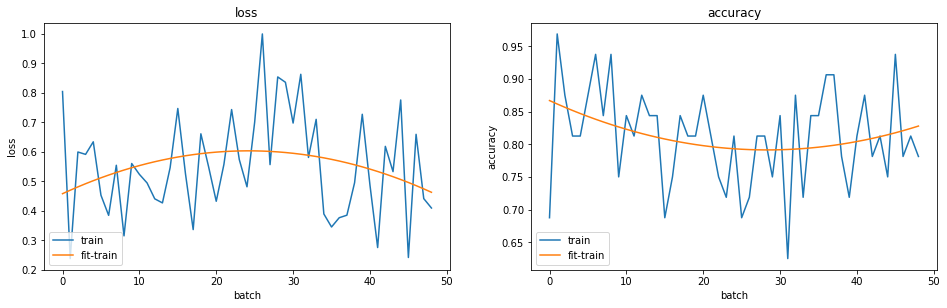

Epoch 6/12
49/49 [==============================] - 25s 516ms/step - loss: 0.4222 - acc: 0.8663 - val_loss: 1.0598 - val_acc: 0.6960


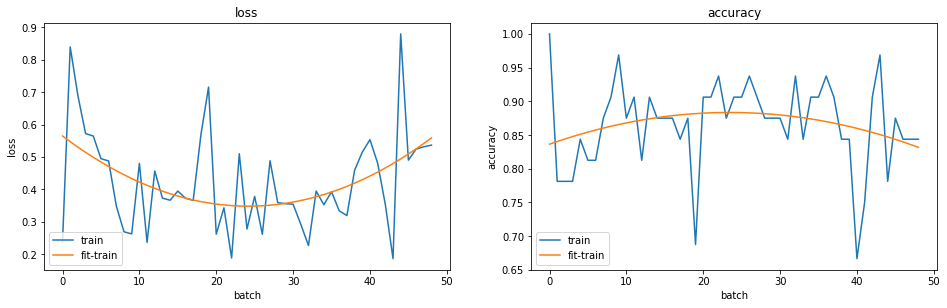


Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.000200000009499.
Epoch 7/12
49/49 [==============================] - 25s 502ms/step - loss: 0.2770 - acc: 0.9222 - val_loss: 0.4078 - val_acc: 0.8670


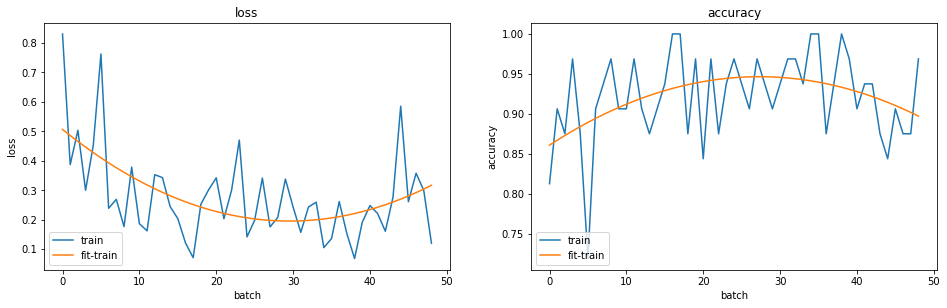

Epoch 8/12
49/49 [==============================] - 24s 496ms/step - loss: 0.1780 - acc: 0.9456 - val_loss: 0.2698 - val_acc: 0.9216


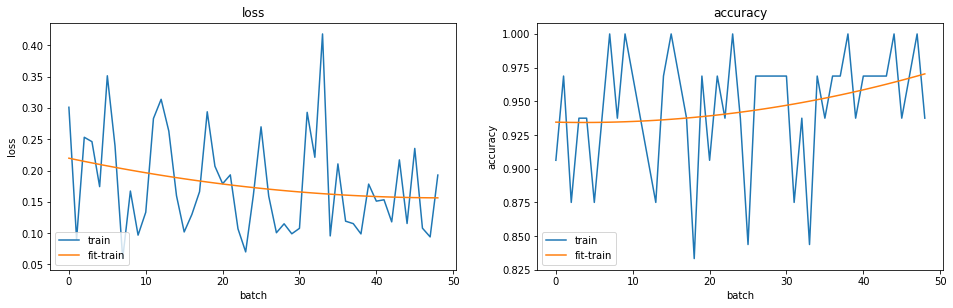

Epoch 9/12
49/49 [==============================] - 24s 484ms/step - loss: 0.1952 - acc: 0.9453 - val_loss: 0.2262 - val_acc: 0.9382


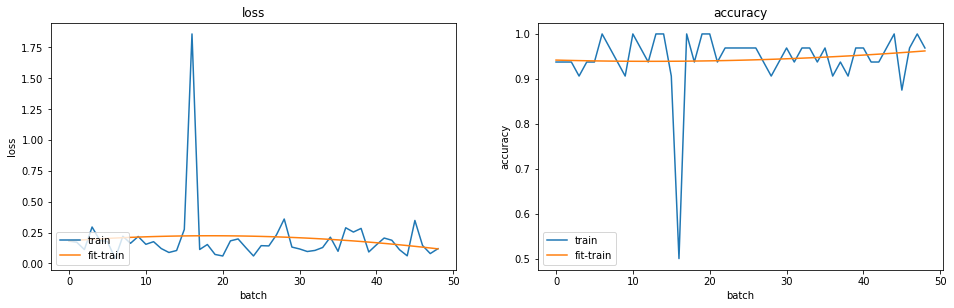

Epoch 10/12
49/49 [==============================] - 24s 499ms/step - loss: 0.1421 - acc: 0.9603 - val_loss: 0.1843 - val_acc: 0.9477


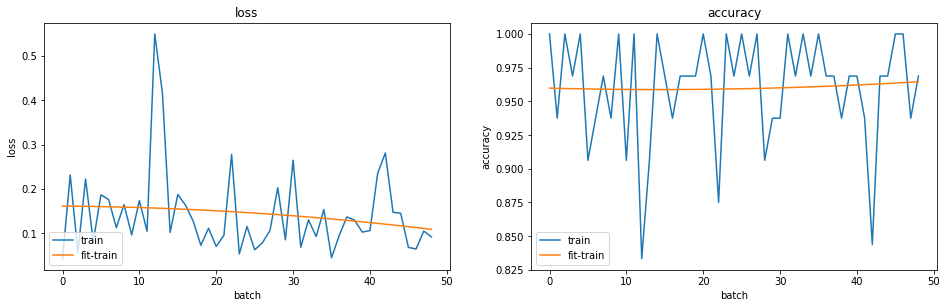

Epoch 11/12
49/49 [==============================] - 25s 508ms/step - loss: 0.1243 - acc: 0.9635 - val_loss: 0.2180 - val_acc: 0.9359


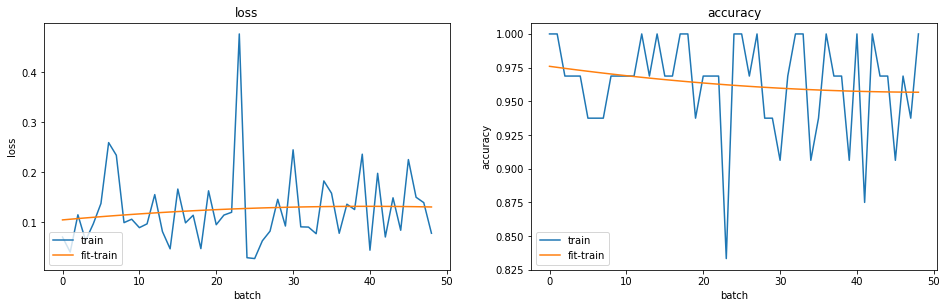

Epoch 12/12
49/49 [==============================] - 25s 501ms/step - loss: 0.1131 - acc: 0.9662 - val_loss: 0.1942 - val_acc: 0.9430


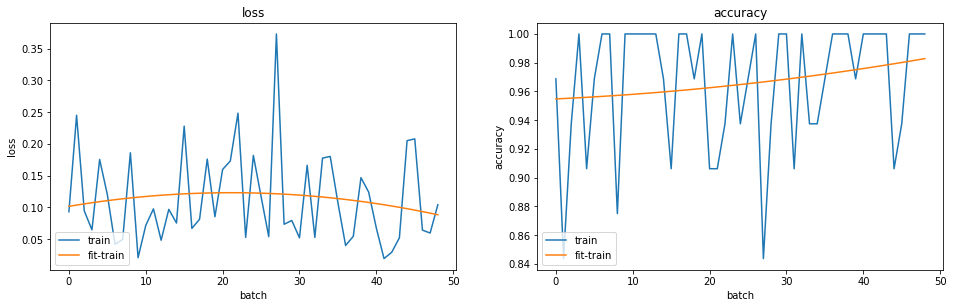

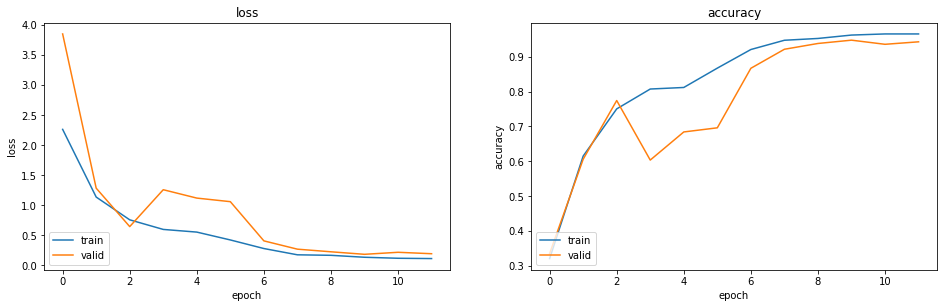

In [9]:
conv_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
fit_generator(
    conv_model, 
    train_flow, 
    valid_flow, 
    epochs=12, 
    callbacks=[lr_decay]
)

In [14]:
conv_model.evaluate_generator(test_flow)

[0.20708078017659753, 0.9457053849577214]

## Submit result 

### data flow

In [16]:
submit_flow = wrap_data_gen(pjoin(data_path, 'test')).flow_from_directory()
submit_model = fc_model

Found 79726 images belonging to 1 classes.


In [17]:
predictions = submit_model.predict_generator(submit_flow)

In [27]:
filenames = np.array([[name.split('/')[1]] for name in submit_flow.filenames])

In [41]:
submit = np.hstack([filenames, predictions])

In [44]:
submit_name = 'submit_fc_one_hidden.csv'
np.savetxt(submit_name, submit, fmt='%s' + ',%s'*10, header='img,{}'.format(','.join(train_flow.class_indices.keys())), comments='')

In [46]:
cli.submit_result(submit_name)